In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [11]:
from sklearn.tree import export_graphviz
plt.rc('pdf', fonttype=42)
#import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

# Read in Data

In [12]:
# Master dataframe with all columns, including `memory_bound` and `master_index`.
# Each row corresponds to distinct architecture and run

df_master = pd.read_parquet('../df_master.parquet')
df_master.master_index = df_master.master_index.astype('int64') # Make sure index is integer
df_master.shape

(78330, 122)

In [13]:
df_master

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,architecture,application_name,input,memory_bound,master_index
0,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002058,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.047434,0,1,P100,backprop,-100000_bpnn_adjust_weights_cuda,0,0
1,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.000633,0.645833,0.696429,0.0,0.0,...,0.0,0.004695,0.000000,0,1,P100,backprop,-100000_bpnn_layerforward_CUDA,0,1
2,56.00560,bpnn_adjust_weights_cuda,1.0,0.999950,0.999948,0.016234,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.043993,0,1,P100,backprop,-10000_bpnn_adjust_weights_cuda,0,2
3,184.00000,bpnn_layerforward_CUDA,1.0,0.943953,0.761888,0.006918,0.645833,0.696429,0.0,0.0,...,0.0,0.003017,0.000000,0,1,P100,backprop,-10000_bpnn_layerforward_CUDA,0,3
4,56.00056,bpnn_adjust_weights_cuda,1.0,0.999995,0.999994,0.002492,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.048306,0,1,P100,backprop,-100016_bpnn_adjust_weights_cuda,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78325,123.00000,STREAM_Add,1.0,1.000000,0.952235,0.042877,0.000000,0.000000,0.0,0.0,...,0.0,0.001050,0.000000,0,1,V100,stream,N99968_STREAM_Add,0,78325
78326,120.00000,STREAM_Copy,1.0,1.000000,0.951041,0.049354,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0,1,V100,stream,N99968_STREAM_Copy,0,78326
78327,121.00000,STREAM_Scale,1.0,1.000000,0.951446,0.047521,0.000000,0.000000,0.0,0.0,...,0.0,0.001094,0.000000,0,1,V100,stream,N99968_STREAM_Scale,0,78327
78328,123.00000,STREAM_Triad,1.0,1.000000,0.952235,0.040356,0.000000,0.000000,0.0,0.0,...,0.0,0.002153,0.000000,0,1,V100,stream,N99968_STREAM_Triad,0,78328


In [14]:
# Combining V100 and P100 on same row for same run
# We are deleting cases where there is no run for either of the architectures
# Every column name is appended with the name of the architecture (e.g. "_V100");
# This includes the `master_index` (e.g `master_index_V100`)

df_joined = pd.read_parquet('../df_master_joined.parquet')
df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
df_joined.shape

(32291, 244)

In [15]:
max(df_joined['ipc_V100'])
max(df_joined['ipc_P100'])

1.893835

In [16]:
v100_membound = df_joined[df_joined['memory_bound_V100']==1]
v100_mb_kernels = v100_membound['kernelname_V100']
ipc_p100 = v100_membound['ipc_P100']
ipc_v100 = v100_membound['ipc_V100']
ipc_difference_p100_v100 = ipc_p100 - ipc_v100
#ipc_difference_p100_v100[ipc_difference_p100_v100 < 0]

In [17]:
# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape


(78330, 116)

In [18]:
kernels = []
for i in df_joined['application_name_V100']:
    if i not in kernels:
        kernels.append(i)

In [19]:
kernels

['backprop', 'gaussian', 'hybridsort', 'kmeans', 'leukocyte', 'srad', 'stream']

## Removing one application from training set to be predicted on
Options: 'backprop', 'gaussian', 'hybridsort', 'kmeans', 'leukocyte', 'srad'

In [20]:
df = df_joined.copy()  
kernel_name = 'kmeans'
#saving gaussian kernel for input and output testing
target_g = df[df['application_name_V100']==kernel_name]
input_x = df[df['application_name_P100']==kernel_name]

#dropping gaussian kernels from both v100 and p100 data 
df = df[df.application_name_V100 != kernel_name]
df = df[df.application_name_P100 != kernel_name]

In [21]:


# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]

In [22]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [23]:

clf = RandomForestClassifier(n_jobs=2, n_estimators=1000,max_depth=2)
#model = clf.fit(X_train, y_train)
model = clf.fit(data,target)

In [24]:
# Simple training-set accuracy calculation
y_test_predict = clf.predict(X_test)

correct = 0
for p, t in zip(y_test_predict, y_test):
    if p == t:
        correct += 1
accuracy = correct / len(y_test)
accuracy

0.9702998846597463

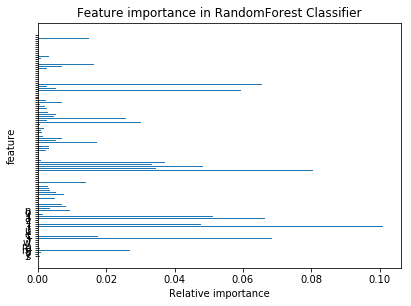

<Figure size 360x360 with 0 Axes>

In [25]:
y = model.feature_importances_
width = 0.4
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width)
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.xlabel("Relative importance")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [26]:
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model.estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=col_names,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

NameError: name 'col_names' is not defined

In [ ]:
df_columns_only.columns.drop(['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions'])

In [ ]:
estimator = clf.estimators_[4]
export_graphviz(estimator, out_file='tree.dot',feature_names = df_columns_only.columns.drop(['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']),
                class_names='memory_bound_V100',rounded=True,
                proportion=False, precision=2, filled=True)

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [ ]:
#trees.explain_prediction_path(model, X, feature_names=df_columns_only.columns.drop(['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']),explanation_type="sklearn_default")

col_names = df_columns_only.columns.drop(['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions'])
clf = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X_train,y_train)
viz = dtreeviz(clf, 
               X_train,
               y_train,
               target_name='memory_bound_V100',
               feature_names=col_names, 
               class_names=["True", "False"],
               orientation='LR')
viz



In [ ]:
dtreeviz(clf,
         X_train,
         y_train,
         target_name="memory_bound_V00",
         feature_names=col_names,
         scale=1.5
        )

In [ ]:
viz = dtreeviz(clf,
               X_train,
               y_train,
               target_name='memory_bound_V100',  # this name will be displayed at the leaf node
               feature_names=col_names,
               title="Memory Bound Prediction",
               fontname="Arial",
               title_fontsize=16,
               colors = {"title":"green"}
              )
viz

## Predicting kernel that was not in training data

In [ ]:
target_g_data = target_g['memory_bound_V100'].values
data_index_m = input_x['master_index_P100'].values
data_m = master_data_scaled[data_index_m]
data_m = data_m[:,indices]

In [ ]:
# Simple training-set accuracy calculation
y_test_predict_m = clf.predict(data_m)
correct = 0
for p, t in zip(y_test_predict_m, target_g_data):
    if p == t:
        correct += 1
accuracy = correct / len(target_g_data)
accuracy

In [ ]:
print('Entire sample size: ', len(data))
print('length of training example:',len(X_train))
print('length of target input:', len(target_g_data))
print('total data of kernel:', len(data_m))

Accuracy for predicting <br>
1. backprop = 87.04 <br>
2. stream = 96.63  <br>
3. leukocyte = 66.66 -100 <br>
4. hybridsort =  1 <br>
5. kmeans = 75.16 <br>
6. srad = 62.50<br>

In [ ]:
#dataframe where 
#Kernel name, accuracy all data, accuracy split data, training size, kernel data points
accuracy_results = {'kernel name':[], 
                    'accuracy - all data':[], 
                    'accuracy - split':[],
                    'training size':[],
                    'kernel size':[]}
#df_accuracy = pd.DataFrame(accuracy_results)

In [ ]:
accuracy_results['kernel name'] = 'stream'

In [29]:
# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


In [30]:
# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape

(78330, 116)

In [31]:
#master_data_scaled

In [32]:
master_data_scaled

array([[-0.0635103 ,  0.38663447,  0.49002807, ...,  1.72897319,
         0.        ,  0.        ],
       [-0.06273309,  0.38663447, -0.03722028, ..., -0.56821609,
         0.        ,  0.        ],
       [-0.06351026,  0.38663447,  0.48960471, ...,  1.56235606,
         0.        ,  0.        ],
       ...,
       [-0.06311562,  0.38663447,  0.49007511, ..., -0.56821609,
         0.        ,  0.        ],
       [-0.06310348,  0.38663447,  0.49007511, ..., -0.56821609,
         0.        ,  0.        ],
       [-0.06312776,  0.38663447,  0.49007511, ..., -0.56821609,
         0.        ,  0.        ]])

# P100 to V100 Memory-bound Classifier

In [33]:
from sklearn.model_selection import train_test_split

df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]

In [34]:
sum(target)

3235

In [35]:
df[['master_index_V100', 'memory_bound_V100','master_index_P100']]

,master_index_V100,memory_bound_V100,master_index_P100
unique_index,,,
bpnn_adjust_weights_cuda_-100000_bpnn_adjust_weights_cuda,19996,0,0
bpnn_layerforward_CUDA_-100000_bpnn_layerforward_CUDA,19997,0,1
bpnn_adjust_weights_cuda_-10000_bpnn_adjust_weights_cuda,19998,0,2
bpnn_layerforward_CUDA_-10000_bpnn_layerforward_CUDA,19999,0,3
bpnn_adjust_weights_cuda_-100016_bpnn_adjust_weights_cuda,20000,0,4
...,...,...,...
STREAM_Add_N99968_STREAM_Add,78325,0,67320
STREAM_Copy_N99968_STREAM_Copy,78326,0,67321
STREAM_Scale_N99968_STREAM_Scale,78327,0,67322


In [36]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

## Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=2, n_estimators=1000)
model = clf.fit(X_train, y_train)

In [38]:

model.feature_importances_.shape
#columns_feature = [c for c in df_columns_only.columns if c not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']]
#columns_feature = [c for c in df_columns_only.columns if c not in not_import]



(112,)

In [39]:
import_feat = pd.DataFrame({'Variable':columns_feature,
             'Importance':model.feature_importances_}).sort_values("Importance", ascending=False)

NameError: name 'columns_feature' is not defined

In [ ]:
import_feat.shape

import_feat


In [ ]:
not_import = []
for x in import_feat.values:
    if 0 in x or x[1] < .04:
        not_import.append(x[0])
len(not_import)
#not_import 

In [ ]:
# Simple training-set accuracy calculation
y_test_predict = clf.predict(X_test)

correct = 0
for p, t in zip(y_test_predict, y_test):
    if p == t:
        correct += 1
accuracy = correct / len(y_test)
accuracy

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_predict)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
print(cm)

In [ ]:
all_prediction = clf.predict(data)
all_prediction.sum() / len(all_prediction)

## Baseline Comparison

In [ ]:
V100_throughput = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
P100_throughput = (df_joined['dram_read_throughput_P100'] + df_joined['dram_write_throughput_P100']).values
plt.plot(V100_throughput/1024/1024/1024, P100_throughput/1024/1024/1024,'.')
plt.xlabel('P100 Throughput')
plt.ylabel('V100 Throughput')
errors = abs(V100_throughput - P100_throughput)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("R2 Score", r2_score(V100_throughput,P100_throughput))
plt.title('Baseline Throughput - MAE: ' + str(mean_error))
plt.savefig('Throughput_Prediction_Figures/predict_result.pdf')

## Regression

In [ ]:
"""for i, col in enumerate(df_joined.columns):
    print(col)"""

In [51]:
df_target = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values

In [52]:
not_import.append('dram_write_transactions')
not_import.append('dram_read_transactions')
not_import.append('dram_write_throughput')
not_import.append('dram_read_throughput')
#not_import.append('l2_tex_write_transactions')

NameError: name 'not_import' is not defined

In [53]:
#not_import

In [ ]:
from sklearn.model_selection import train_test_split

df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
#target_index = df['master_index_V100'].values
target = df_target #df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    #if col not in ['dram_read_throughput', 'dram_write_throughput']:
    if col not in not_import:
        indices.append(i)
        print(col)
data = data[:,indices]

In [ ]:
df_columns_only

In [ ]:
num_features = data.shape[1]

In [ ]:
#df_joined[['master_index_V100']].tail()

In [ ]:
#df_joined[['master_index_P100']].head()

In [ ]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    random_state=42,
    test_size=.33
)

In [ ]:
y_test_gb = y_test/1024/1024/1024

In [54]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_jobs=2, n_estimators=1000, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [43]:
from sklearn.metrics import mean_absolute_percentage_error
y_test_predict = clf.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test,y_test_predict))

Mean Absolute Error: 0.0
Mean absolute percentage error: 48598475851328.44


In [48]:
y_test_predict_gb = y_test_predict/1024/1024/1024
y_test_gb = y_test/1024/1024/1024

In [49]:
print("R2 Score", r2_score(y_test_gb,y_test_predict_gb))
print("Mean Squared error", mean_squared_error(y_test_gb,y_test_predict_gb, squared=False))

R2 Score 0.6888438781991464
Mean Squared error 1.5651857849994417e-10


R2 Score 0.6888438781991464


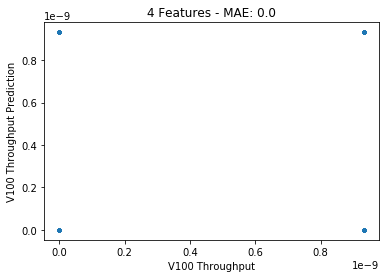

In [50]:
plt.plot(y_test_gb, y_test_predict_gb,'.')
plt.xlabel('V100 Throughput')
plt.ylabel('V100 Throughput Prediction')
plt.title('4 Features - MAE: ' + str(mean_error))
print("R2 Score", r2_score(y_test_gb,y_test_predict_gb))
#plt.savefig('Throughput_Prediction_Figures/predict_result.pdf')

In [34]:
"""y_test = y_test/1024/1024/1024
for n in y_train:
    if n != 0:
        print (n)"""

'y_test = y_test/1024/1024/1024\nfor n in y_train:\n    if n != 0:\n        print (n)'

## XGBOOST

In [115]:
import xgboost as xgb

In [116]:
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    random_state=42,
    test_size=.2
)
(
    X_train, X_val,
    y_train, y_val,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    X_train,
    y_train,
    random_state=42,
    test_size=.25
)

In [117]:
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    target,
    random_state=42,
    test_size=.33
)
model = xgb.XGBRegressor(n_estimators=1000, max_depth=150, eta=0.1, subsample=0.7, colsample_bytree=0.8)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:404770848768.00000	validation_0-mae:296082210816.00000	validation_1-rmse:404292108288.00000	validation_1-mae:295602126848.00000
[1]	validation_0-rmse:364561203200.00000	validation_0-mae:266630316032.00000	validation_1-rmse:364200951808.00000	validation_1-mae:266272964608.00000
[2]	validation_0-rmse:328359313408.00000	validation_0-mae:240089645056.00000	validation_1-rmse:328098873344.00000	validation_1-mae:239838806016.00000
[3]	validation_0-rmse:295807713280.00000	validation_0-mae:216213897216.00000	validation_1-rmse:295636893696.00000	validation_1-mae:216063672320.00000
[4]	validation_0-rmse:266504044544.00000	validation_0-mae:194736062464.00000	validation_1-rmse:266455416832.00000	validation_1-mae:194708750336.00000
[5]	validation_0-rmse:240146661376.00000	validation_0-mae:175392522240.00000	validation_1-rmse:240233398272.00000	validation_1-mae:175504769024.00000
[6]	validation_0-rmse:216433115136.00000	validation_0-mae:157980606464.00000	validation_1-rmse:21665

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=150,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
y_test_predict = model.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))

Mean Absolute Error: 14.44


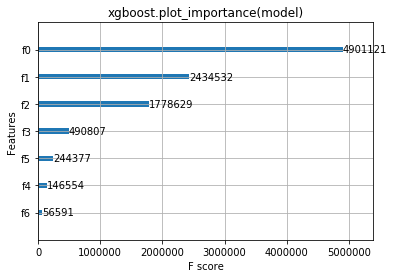

In [119]:
xgb.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [120]:
yptest_gb = y_test_predict/1024/1024/1024
ytest_gb = y_test/1024/1024/1024


R2 Score 0.9868406738434874


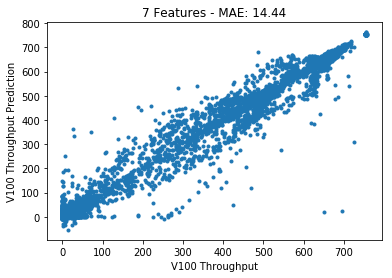

In [122]:
plt.plot(ytest_gb, yptest_gb,'.')
plt.xlabel('V100 Throughput')
plt.ylabel('V100 Throughput Prediction')
plt.title('7 Features - MAE: ' + str(mean_error))
print("R2 Score", r2_score(ytest_gb,yptest_gb))

In [41]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
X,y = data,target
cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=1)
scores = cross_val_score(model,X,y,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [42]:
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 13658094306.261 (287125745.317)


In [212]:
mape = 100 * (errors/y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: -inf %.


/Users/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [56]:
true_indices = []
for i, (ind0, ind1) in enumerate(zip(data_index, target_index)):
    if all_prediction[i] == 1:
        true_indices.append(ind0)
        true_indices.append(ind1)
true_indices = np.array(true_indices)


# Save true_indices to 'predicted_v100_memory_bound_indices.npy'
np.save('predicted_v100_memory_bound_indices.npy', true_indices)

In [67]:
true_indices

NameError: name 'true_indices' is not defined

# Generate "Predicted" Dataframe

Let's create a dataframe of Cases with V100 memory-bound predictions.

In [210]:
real_index = []
for i, val in enumerate(df_master['master_index']):
    if val in true_indices:
        real_index.append(i)
        
df_predicted = df_master.iloc[real_index].copy()
df_write = df_predicted.drop(['master_index', 'memory_bound'], axis=1).copy()
df_write[df_write['architecture'] == 'V100'].to_csv('predicted_true_v100.csv', index=False)
df_write[df_write['architecture'] == 'P100'].to_csv('predicted_true_p100.csv', index=False)

In [222]:
df_test_p100 = pd.read_csv('predicted_true_p100.csv')
df_test_v100 = pd.read_csv('predicted_true_v100.csv')
df_test_v100.shape

(3168, 120)

In [224]:
p100_dram_only = df_test_p100[['dram_read_throughput','dram_write_throughput']]
v100_dram_only = df_test_p100[['dram_read_throughput','dram_write_throughput']]
p100_dram_only.shape

(3168, 2)

In [212]:
backprop_ind_p100 = df_test_p100[df_test_p100['application_name']=='backprop'].index.values

# Use random 10%
fraction_include = 0.1
n_backprop = len(backprop_ind_p100)
backprop_ind_p100 = backprop_ind_p100[np.random.permutation(n_backprop)][:int(n_backprop*fraction_include)]
other_ind_p100 = df_test_p100[df_test_p100['application_name']!='backprop'].index.values
use_ind_p100 = np.sort( np.concatenate( (backprop_ind_p100, other_ind_p100) ) )

df_test_p100 = df_test_p100.loc[use_ind_p100]

In [213]:
backprop_ind_v100 = df_test_v100[df_test_v100['application_name']=='backprop'].index.values

# Use random 10%
fraction_include = 0.1
n_backprop = len(backprop_ind_v100)
backprop_ind_v100 = backprop_ind_v100[np.random.permutation(n_backprop)][:int(n_backprop*fraction_include)]
other_ind_v100 = df_test_v100[df_test_v100['application_name']!='backprop'].index.values
use_ind_v100 = np.sort( np.concatenate( (backprop_ind_v100, other_ind_v100) ) )

df_test_v100 = df_test_v100.loc[use_ind_v100]

In [214]:
int(n_backprop*fraction_include)

252

In [215]:
# acquiring 20% from each
##df_test_p100 = df_test_p100.drop(['architecture','input','application_name','kernelname'],axis=1)
##df_test_v100 = df_test_v100.drop(['architecture','input','application_name','kernelname'],axis=1)

In [216]:
rand_ind = np.random.permutation(len(df_test_v100.index))

In [217]:
n_train_v100 = int(0.2*len(df_test_v100.index))
test_ind_v100 = rand_ind[:n_train_v100+1]
train_ind_v100 = rand_ind[n_train_v100+1:]

n_train_p100 = int(0.2*len(df_test_p100.index))
test_ind_p100 = rand_ind[:n_train_p100+1]
train_ind_p100 = rand_ind[n_train_p100+1:]

print(train_ind_v100.shape)
print(test_ind_v100.shape)

print(train_ind_p100.shape)
print(test_ind_p100.shape)

(715,)
(179,)
(715,)
(179,)


In [218]:
X_test_v100 = df_test_v100.iloc[test_ind_v100].values
X_test_p100 = df_test_p100.iloc[test_ind_p100].values

X_train_v100 = df_test_v100.iloc[train_ind_v100]
X_train_p100 = df_test_p100.iloc[train_ind_p100]

In [219]:
X_train_v100.to_csv('train_predicted_true_v100.csv', index=False)
X_train_p100.to_csv('train_predicted_true_p100.csv', index=False)

#X_test_v100.to_csv('test_predicted_true_v100.csv', index=False)
#X_test_p100.to_csv('test_predicted_true_p100.csv', index=False)

In [209]:
np.save('X_predicted_test_v100',X_test_v100)
np.save('X_predicted_test_p100',X_test_p100)

#np.save('X_predicted_train_v100',X_train_v100)
#np.save('X_predicted_train_p100',X_train_p100)